---
header-includes: 
  - $\newcommand{\s}{\mathbf{s}}$
---

# On an Anisotropic Heisenberg Model

We proceed to analyze a 1D-lattice system, on which the sites are vector valued -- i.e., each site is assigned a 3D vector $\s _i = (s_i^x, s_i^y, s_i^z)^T$ -- further imposing the constraint $\|\s_i\| = 1\; \forall i$, and with an energy function

$$H(\{\s\}) = -J\sum_{\langle i j \rangle}\s_i \cdot \s_j + g\sum_i \left[(s_i^z)^2 - \frac{1}{2}\left((s_i^x)^2+(s_i^y)^2\right)\right]$$

This model is quite interesting, as it exhibits both first and second order phase transitions. We will proceed to discuss this system intuitively, and then proceed too run numerics and visualizations.

## A brief look at the phase transition structure.

We claim that the phase transition diagram looks as follows:

Indeed, we consider the 

We start by looking at the 1D system. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from visualization.lattice_plots import make_1D_spin_plot, make_1D_spin_animation
from Lattice1D.lattice import Lattice
from tqdm import tqdm
from numpy import random

STEPS = 400
TRIALS = 10

J, g, beta = 1, 1, 1
N = 60
def vectorized_result(seed, J, g, beta):
    rng_init = random.default_rng(seed)
    seeds = rng_init.integers(0, 2**32, size=TRIALS)

    def result(seed):
        rng = random.default_rng(seed)
        newlattice = Lattice(N, rng, "hot")
        Lattice_results = newlattice.MC_evolution(STEPS, J, g, beta, animate=False)
        return (Lattice_results["actions"], newlattice.spins)
    vectorized_func = np.vectorize(result, otypes=[tuple])

    return vectorized_func(seeds)

results = vectorized_result(0, J, g, beta)
actions = np.array([result[0] for result in results])
spins = np.array([result[1] for result in results])
print(actions.shape)
print(spins.shape)

(10, 400)
(10, 60, 3)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from visualization.lattice_plots import make_1D_spin_plot, make_1D_spin_animation
from Lattice1D.lattice import Lattice
from tqdm import tqdm
from numpy import random

STEPS = 400
TRIALS = 10

J, g, beta = 1, 1, 1
N = 60
rng = random.default_rng(42)
actions, spins = np.zeros((TRIALS, STEPS)), np.zeros((TRIALS, N, 3))
for idx in tqdm(range(TRIALS)):
    newlattice = Lattice(N, rng, "hot")
    Lattice_results = newlattice.MC_evolution(STEPS, J, g, beta, animate=False)
    actions[idx], spins[idx] = Lattice_results["actions"], newlattice.spins

print(actions.shape)
print(spins.shape)

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]

(10, 400)
(10, 60, 3)


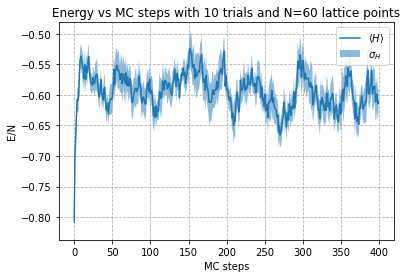

In [4]:

action_means = np.mean(actions, axis=0)
action_stds = np.std(actions, axis=0)/np.sqrt(TRIALS)
plt.plot(np.arange(STEPS), action_means, label=r'$\langle H \rangle$')
plt.fill_between(np.arange(STEPS), action_means-action_stds,
                    action_means+action_stds, alpha=0.5, label=r'$\sigma_H$')
plt.legend()
plt.xlabel("MC steps")
plt.ylabel("E/N")
plt.grid(ls="--")
plt.title(f"Energy vs MC steps with {TRIALS} trials and N={N} lattice points")
plt.savefig("images/energy_thermalization_1D.pdf")
# make_1D_spin_animation(animation_data, color='red')
# make_3D_spin_plot(normalized_data, color='red')


In [5]:
vectorized_over_gs = np.vectorize(vectorized_result, excluded=[1, 3], otypes=[np.ndarray])
beta = 10
init_rng = random.default_rng(42)
gs = np.linspace(-1, 1, 20)
seeds = init_rng.integers(0, 2**32, size=len(gs))
results_vs_g = vectorized_over_gs(seeds, J, gs, beta)

actions_vs_g, spins_vs_g = np.zeros((len(gs), TRIALS)), np.zeros((len(gs), TRIALS, N, 3))
print(results_vs_g.shape)
for idx, elem in enumerate(results_vs_g):
    for idx2, elem2 in enumerate(elem):
        actions_vs_g[idx, idx2], spins_vs_g[idx, idx2] = elem2[0][-1], elem2[1][-1]





(20,)


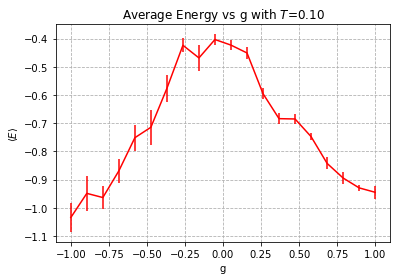

In [6]:
# plt.scatter(gs, action_means, color='red', ls='--')
action_means = np.mean(actions_vs_g, axis=1)
action_stds = np.std(actions_vs_g, axis=1)/np.sqrt(TRIALS)
plt.errorbar(gs, action_means, yerr=action_stds, color='red')
plt.xlabel("g") 
plt.ylabel(r"$\langle E \rangle$")
plt.grid(ls="--")
plt.title(f"Average Energy vs g with $T$={1/beta:.2f}")
plt.savefig("images/energy_vs_g_1D.pdf")


(20, 10)
(20, 10, 60, 3)


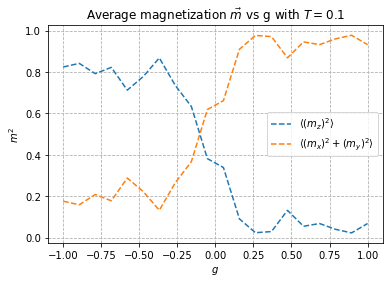

In [7]:

def avg_magnetization(spin_list: np.ndarray, actions: np.ndarray):
    """Calculate the average magnetization of a given spin configuration"""
    weights = np.exp(-actions)
    print(weights.shape)
    print(spin_list.shape)
    Z = np.sum(weights, axis=1)
    avg_msquared= np.sum(spin_list**2*weights[:, :, None, None]/Z[:,None,None,None], axis=(1))
    return avg_msquared

magnetizations = avg_magnetization(spins_vs_g, actions_vs_g)
m = np.mean(magnetizations, axis=1)
# print(m.shape)
plt.plot(gs, m[:, 2], label=r"$\langle (m_z)^2 \rangle$", ls="--")
plt.plot(gs, m[:, 0]+m[:,1], label=r"$\langle (m_x)^2+(m_y)^2 \rangle$", ls="--")
plt.legend()
plt.grid(ls="--")
plt.xlabel(r"$g$")
plt.ylabel(r"$m^2$")
plt.title(r"Average magnetization $\vec{m}$ vs g with" +f" $T={1/beta}$")
plt.savefig("images/magnetization_1D.pdf")
plt.show()

In [8]:
vectorized_over_betas = np.vectorize(vectorized_result, excluded=[1, 2], otypes=[np.ndarray])
g = 0.5
init_rng = random.default_rng(42)
T = np.concatenate([np.linspace(0.1, 1, 15), np.linspace(1.1,10, 25)])
betas = 1/T
seeds = init_rng.integers(0, 2**32, size=len(betas))
results_vs_betas = vectorized_over_betas(seeds, J, g, betas)

actions_vs_betas, spins_vs_betas = np.zeros((len(betas), TRIALS)),\
                                    np.zeros((len(betas), TRIALS, N, 3))
for idx, elem in enumerate(results_vs_betas):
    for idx2, elem2 in enumerate(elem):
        actions_vs_betas[idx, idx2], spins_vs_betas[idx, idx2] = elem2[0][-1], elem2[1][-1]

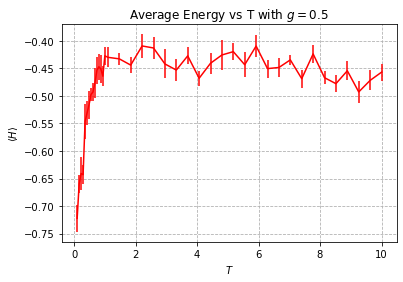

In [9]:
action_means = np.mean(actions_vs_betas, axis=1)
action_stds = np.std(actions_vs_betas, axis=1)/np.sqrt(TRIALS)
plt.errorbar(T, action_means, yerr=action_stds, color='red')
plt.xlabel(r"$T$") 
plt.ylabel(r"$\langle H \rangle$")
plt.grid(ls="--")
plt.title(f"Average Energy vs T with $g={g}$")
plt.savefig("images/energy_vs_betas_1D_gpos.pdf")

(40, 10)
(40, 10, 60, 3)


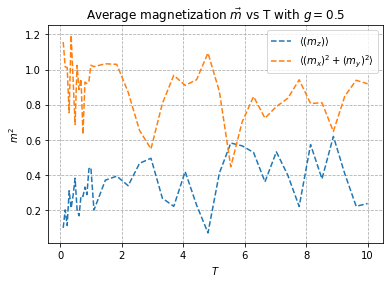

In [10]:
def avg_magnetization(spin_list: np.ndarray, actions: np.ndarray):
    """Calculate the average magnetization of a given spin configuration"""
    weights = np.exp(-actions)
    print(weights.shape)
    print(spin_list.shape)
    Z = np.sum(weights, axis=1)
    avg_msquared= np.sum(spin_list*weights[:, :, None, None]/Z[:,None,None,None], axis=(1))
    return avg_msquared

magnetizations = avg_magnetization(spins_vs_betas, actions_vs_betas)
m = np.mean(magnetizations, axis=1)
# print(m.shape)
plt.plot(1/betas, m[:, 2], label=r"$\langle (m_z) \rangle$", ls="--")
plt.plot(1/betas, m[:, 0]+m[:,1], label=r"$\langle (m_x)^2+(m_y)^2 \rangle$", ls="--")
plt.legend()
plt.grid(ls="--")
plt.xlabel(r"$T$")
plt.ylabel(r"$m^2$")
plt.title(r"Average magnetization $\vec{m}$ vs T with" +f" $g={g}$")
plt.savefig("images/magnetization_1D_vs_T_gpos.pdf")
plt.show()

In [11]:
g_neg = -0.5
seeds = init_rng.integers(0, 2**32, size=len(betas))
results_vs_betas_neg = vectorized_over_betas(seeds, J, g_neg, betas)

actions_vs_betas_neg, spins_vs_betas_neg = np.zeros((len(betas), TRIALS)),\
                                    np.zeros((len(betas), TRIALS, N, 3))
for idx, elem in enumerate(results_vs_betas_neg):
    for idx2, elem2 in enumerate(elem):
        actions_vs_betas_neg[idx, idx2], spins_vs_betas_neg[idx, idx2] =\
            elem2[0][-1], elem2[1][-1]

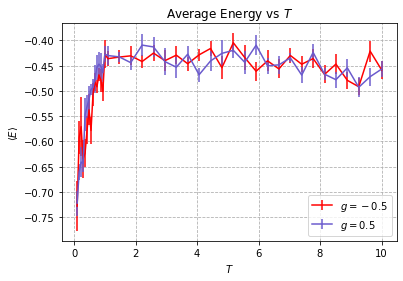

In [16]:
action_means_neg = np.mean(actions_vs_betas_neg, axis=1)
action_stds_neg = np.std(actions_vs_betas_neg, axis=1)/np.sqrt(TRIALS)
plt.errorbar(T, action_means_neg, yerr=action_stds_neg, color='red', label=r'$g=-0.5$')
plt.errorbar(T, action_means, yerr=action_stds, color='slateblue', label=r'$g=0.5$')
plt.legend()
plt.xlabel(r"$T$") 
plt.ylabel(r"$\langle E \rangle$")
plt.grid(ls="--")
plt.title(f"Average Energy vs $T$")
plt.savefig("images/energy_vs_betas_1D_gneg.pdf")

(40, 10)
(40, 10, 60, 3)


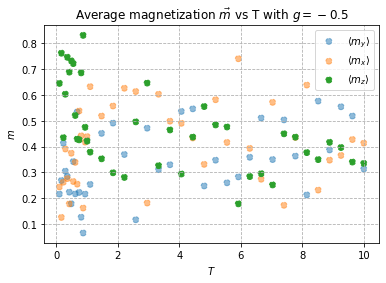

In [17]:
def avg_magnetization(spin_list: np.ndarray, actions: np.ndarray):
    """Calculate the average magnetization of a given spin configuration"""
    weights = np.exp(-actions)
    print(weights.shape)
    print(spin_list.shape)
    Z = np.sum(weights, axis=1)
    avg_msquared= np.sum(spin_list*weights[:, :, None, None]/Z[:,None,None,None], axis=(1))
    return avg_msquared

magnetizations_neg = avg_magnetization(spins_vs_betas_neg, actions_vs_betas_neg)
m_neg = np.mean(magnetizations_neg, axis=1)
# print(m.shape)
# plt.plot(1/betas, m_neg[:, 2], label=r"$\langle (m_z) \rangle$", ls="--")
# plt.plot(1/betas, m_neg[:, 0], label=r"$\langle (m_x)^2+(m_y)^2 \rangle$", ls="--")
plt.scatter(1/betas, m_neg[:,1], label=r"$\langle m_y \rangle$", ls="--", alpha=0.5)
plt.scatter(1/betas, m_neg[:, 0], label=r"$\langle m_x \rangle$", ls="--", alpha=0.5)
plt.scatter(1/betas, m_neg[:, 2], label=r"$\langle m_z \rangle$", ls="--")
plt.legend()
plt.grid(ls="--")
plt.xlabel(r"$T$")
plt.ylabel(r"$m$")
plt.title(r"Average magnetization $\vec{m}$ vs T with" +f" $g={g_neg}$")
plt.savefig("images/magnetization_1D_vs_T_gneg.pdf")
plt.show()